# Stock-Bot

Decision to buy/sell is made when a certain SMA is crossed.

- get gradiant of all SMAs at that point
- guess price when the stock cross that SMA again

### How?

- when stock cross -> ask experts

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import *

## Pre-processing

In [102]:
companies_df = pd.read_csv('data/sp500_companies.csv')
index_df = pd.read_csv('data/sp500_index.csv')
stocks_df = pd.read_csv('data/sp500_stocks.csv')

In [103]:
companies_df.sort_values(by='Weight', ascending=False).head(3)

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,144.49,2298561429504,1.305410e+11,0.081,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.064839
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software—Infrastructure,252.51,1895839956992,9.798300e+10,0.124,Redmond,WA,United States,221000.0,"Microsoft Corporation develops, licenses, and ...",0.053478
2,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,93.56,1209290981376,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.034112


### Calculate values for a single company

In [104]:
appl_df = stocks_df[stocks_df.Symbol == 'AAPL']
appl_df.sort_values(by='Date').drop(columns=['Symbol', 'Adj Close'])
# appl_df = appl_df.tail(365) # NOTE: gets last year of data
appl_df.head(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
146655,2010-01-04,AAPL,6.572423,7.643214,7.660714,7.585000,7.622500,493729600.0
146656,2010-01-05,AAPL,6.583786,7.656429,7.699643,7.616071,7.664286,601904800.0
146657,2010-01-06,AAPL,6.479064,7.534643,7.686786,7.526786,7.656429,552160000.0
146658,2010-01-07,AAPL,6.467087,7.520714,7.571429,7.466071,7.562500,477131200.0
146659,2010-01-08,AAPL,6.510081,7.570714,7.571429,7.466429,7.510714,447610800.0


In [105]:
ma_sizes = [3, 5, 10, 30]

In [106]:
for size in ma_sizes:
    appl_df[f'SMA{size}'] = appl_df['Close'].rolling(size).mean()
appl_df.dropna(inplace=True)

/var/folders/j_/__b8cqr9627c4f9vjf4yn6p00000gn/T/ipykernel_47664/3127499428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appl_df[f'SMA{size}'] = appl_df['Close'].rolling(size).mean()
/var/folders/j_/__b8cqr9627c4f9vjf4yn6p00000gn/T/ipykernel_47664/3127499428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appl_df[f'SMA{size}'] = appl_df['Close'].rolling(size).mean()
/var/folders/j_/__b8cqr9627c4f9vjf4yn6p00000gn/T/ipykernel_47664/3127499428.py:2: SettingWithCopyWarning: 
A value is trying to be s

<AxesSubplot: >

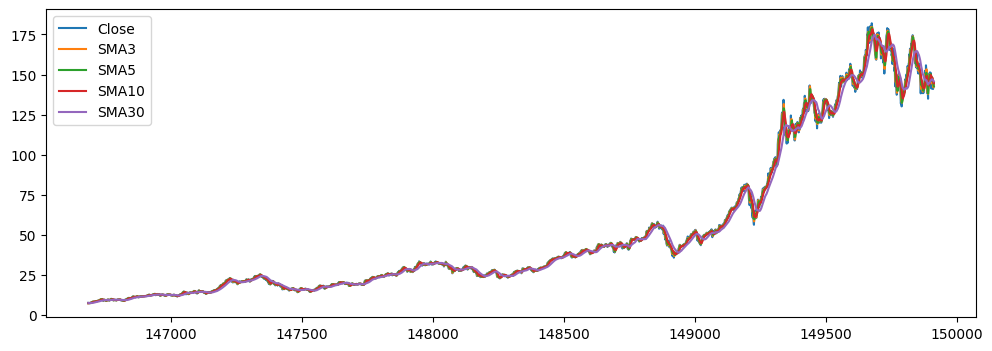

In [107]:
appl_df[['Close', 'SMA3', 'SMA5', 'SMA10', 'SMA30']].plot(label='AAPL', figsize=(12, 4))

In [108]:
# Calculate SMA gradients
for size in ma_sizes:
    appl_df[f'SMA{size}_diff'] = appl_df[f'SMA{size}'] - appl_df[f'SMA{size}'].shift(1)

# Calculate Close value in 5 days time
appl_df['future_close'] = appl_df['Close'].shift(-5) - appl_df['Close']
appl_df.dropna(inplace=True)

/var/folders/j_/__b8cqr9627c4f9vjf4yn6p00000gn/T/ipykernel_47664/1223903438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appl_df[f'SMA{size}_diff'] = appl_df[f'SMA{size}'] - appl_df[f'SMA{size}'].shift(1)
/var/folders/j_/__b8cqr9627c4f9vjf4yn6p00000gn/T/ipykernel_47664/1223903438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appl_df[f'SMA{size}_diff'] = appl_df[f'SMA{size}'] - appl_df[f'SMA{size}'].shift(1)
/var/folders/j_/__b8cqr9627c4f9vjf4yn6p00000gn/T/ipykernel_47664/1223903438.py:3: Settin

### Data prep

In [109]:
df = appl_df[['Date', 'SMA3_diff', 'SMA5_diff', 'SMA10_diff', 'SMA30_diff', 'future_close']].sort_values(by='Date').drop(columns=['Date'])
df['outcome'] = df['future_close'] > 0
df.head(3)

,SMA3_diff,SMA5_diff,SMA10_diff,SMA30_diff,future_close,outcome
146685,0.046191,0.045429,0.023893,-0.013643,-0.067500,False
146686,0.030357,0.055786,0.013214,-0.013631,-0.033214,False
146687,-0.020595,0.021429,0.034357,-0.011071,0.105357,True


In [111]:
# Plotting the correlation coefficients
# sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Reds)

### Train models

#### Regression

In [112]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['future_close', 'outcome']).reset_index(drop=True), df['future_close'].reset_index(drop=True), test_size = 0.2)

In [113]:
def print_statistics(regression_model, name):
    print(f'---------- {name} ----------')
    print(f'Max Error: {max_error(y_test, regression_model.predict(X_test))}')
    print(f'MSE:       {mean_squared_error(y_test, regression_model.predict(X_test))}')
    print(f'MAE:       {mean_absolute_error(y_test, regression_model.predict(X_test))}')
    print(f'R2 Score:  {regression_model.score(X_test, y_test)}')

In [114]:
adaboost = AdaBoostRegressor(n_estimators=50)
adaboost.fit(X_train, y_train)

AdaBoostRegressor()

In [115]:
print_statistics(adaboost, 'AdaBoost')

---------- AdaBoost ----------
Max Error: 16.111205130619453
MSE:       8.174918160139729
MAE:       1.5325016392650217
R2 Score:  -0.03611381023746896


#### Classification

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['future_close', 'outcome']).reset_index(drop=True), df['outcome'].reset_index(drop=True), test_size = 0.2)

In [117]:
ac = AdaBoostClassifier(n_estimators=50)
ac.fit(X_train, y_train)
ac.score(X_test, y_test)

0.5534883720930233